# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                                                     #    The presence of three elements in both the mean and std lists corresponds to the three color channels of an RGB image: Red, Green, and Blue.
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb4c21030a0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 14.461 seconds


### Make predictions on the entire test dataset with the model

In [11]:
from tqdm.auto import tqdm

test_preds = []
model_0.eval()

with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    X, y = X.to(device), y.to(device)

    test_logits = model_0(X)
    test_pred_probs = torch.softmax(test_logits, dim=1)
    test_pred_labels = torch.argmax(test_pred_probs, dim=1)
    test_preds.append(test_pred_labels)

# print(test_preds)
# print(test_preds[0].shape)

test_preds = torch.cat(test_preds).cpu() # put on cpu probably to ensure that the predictions can be processed by libraries that do not support GPU tensors,
                                         # such as some visualization tools or file I/O operations.
test_preds


0it [00:00, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [12]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [13]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [14]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth, test_preds

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
         2, 2, 2]))

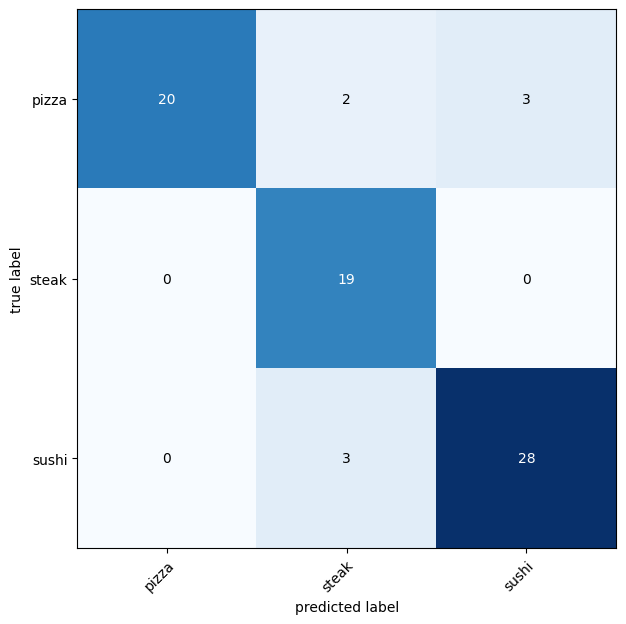

In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(test_preds, test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [16]:
import pandas as pd

from pathlib import Path

test_data_path = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_path]

def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    pred_dict = {}
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0)
    model_0.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))  # necessary to send to device
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # print(pred_prob)
      # print(pred_prob.unsqueeze(0))

      unsqueeze = pred_prob.unsqueeze(0)
      # Preparing for Reduction Operations:
      # Some reduction operations in PyTorch (like max(), sum(), etc.) behave differently depending on the shape of the tensor.
      # By ensuring the tensor has the correct dimensions, the operation will be performed as intended.
      pred_dict["pred_prob"] = unsqueeze.max().cpu().item()
      pred_dict["pred_class"] = pred_class

    pred_dict["correct"] = class_name == pred_class

    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dict = pred_and_store(test_paths=test_data_path,
                                model=model_0,
                                transform=simple_transform,
                                class_names=class_names,
                                device=device)

test_pred_dict[0]

  0%|          | 0/75 [00:00<?, ?it/s]

{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 'class_name': 'pizza',
 'pred_prob': 0.4021509289741516,
 'pred_class': 'pizza',
 'correct': True}

In [17]:
import pandas as pd

test_pred_df = pd.DataFrame(test_pred_dict)
#top_5 = test_pred_df.head(5)

# false_df = test_pred_df[test_pred_df["correct"]==False]
# false_df
# sorted_false_df = false_df.sort_values(by=["pred_prob"], ascending=False)
# sorted_false_df

### OR

top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
56,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.546966,steak,False
57,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.449595,steak,False
23,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.444701,sushi,False
3,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.435138,sushi,False
9,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,0.426874,sushi,False


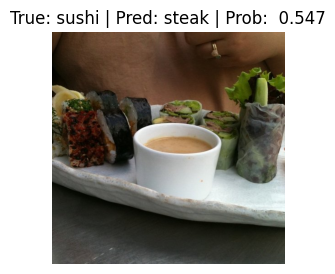

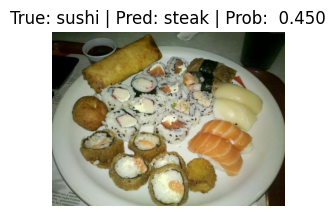

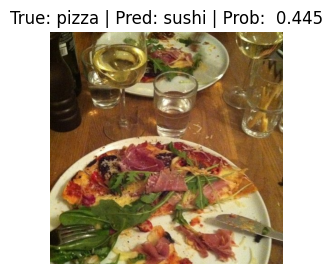

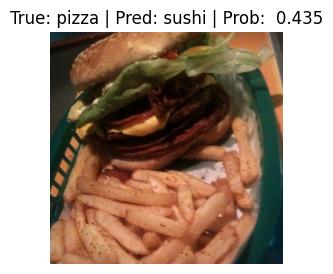

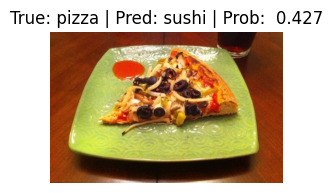

In [18]:
import torchvision
import matplotlib.pyplot as plt

# The iterrows() method generates an iterator over the DataFrame's rows.
# Each row is returned as a tuple, where the first element is the row index and
# the second element is a Series containing the row's data.
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]

  img = torchvision.io.read_image(str(image_path))  # get image as tensor

  plt.figure(figsize=(3, 4))
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob: .3f}")
  plt.axis(False)
  plt.show()

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

--2024-07-23 15:31:47--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.2’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.05s   

2024-07-23 15:31:47 (61.1 MB/s) - ‘photo-1588315029754-2dd089d39a1a.2’ saved [3208960/3208960]



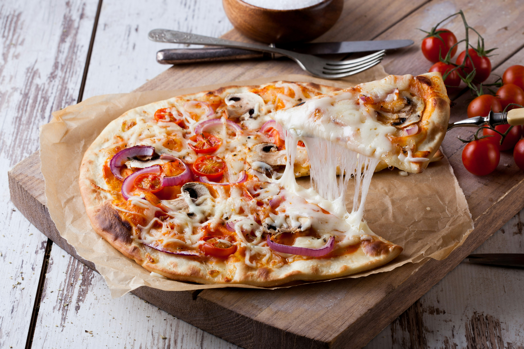

In [19]:
# TODO: Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # reduce the image size by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

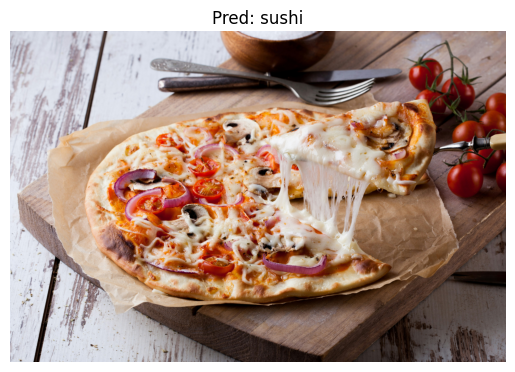

In [21]:
# create a function to predict and plot the images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  with Image.open(image_path) as image:
    transformed_image = transform(image).to(device)

    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image.unsqueeze(0)).to(device)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred_label]}")
    plt.axis(False)

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)


--2024-07-23 15:34:29--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617320 (3.4M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]   3.45M  --.-KB/s    in 0.06s   

2024-07-23 15:34:31 (56.7 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [3617320/3617320]



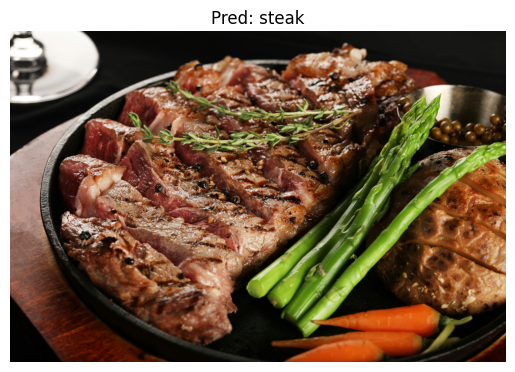

In [22]:
# Try again on a photo of steak from unsplash.com
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-07-23 15:34:37--  https://www.twopeasandtheirpod.com/wp-content/uploads/2023/05/Spaghetti-2226-1024x1536.jpg
Resolving www.twopeasandtheirpod.com (www.twopeasandtheirpod.com)... 104.18.5.29, 104.18.4.29, 2606:4700::6812:51d, ...
Connecting to www.twopeasandtheirpod.com (www.twopeasandtheirpod.com)|104.18.5.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318847 (311K) [image/jpeg]
Saving to: ‘Spaghetti-2226-1024x1536.jpg’

Spaghetti-2226-1024 100%[===================>] 311.37K  --.-KB/s    in 0.03s   

2024-07-23 15:34:38 (11.8 MB/s) - ‘Spaghetti-2226-1024x1536.jpg’ saved [318847/318847]



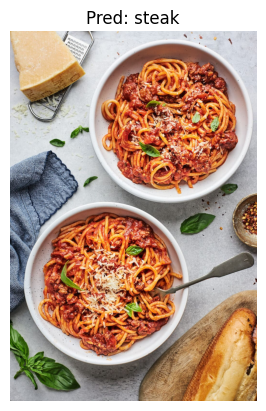

In [23]:
# TODO: Get an image of not pizza/steak/sushi
!wget https://www.twopeasandtheirpod.com/wp-content/uploads/2023/05/Spaghetti-2226-1024x1536.jpg
!cp Spaghetti-2226-1024x1536.jpg spaghetti.jpg

pred_and_plot(image_path="spaghetti.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [24]:
# TODO: Recreate a new model

model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

for param in model_1.parameters():
  param.requires_grad = False

torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)).to(device)

# summary(model_1,
#         input_size=[32, 3, 224, 224],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# TODO: Train the model for 10 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                           lr=0.001)

model_1_results = engine.train(model=model_1,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs = 10,
                               device=device)


end_time = timer()
tot_time = end_time - start_time

print(f"[INFO] Total training time: {tot_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6022 | train_acc: 0.7656 | test_loss: 0.5565 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5411 | train_acc: 0.9258 | test_loss: 0.5279 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5493 | train_acc: 0.8086 | test_loss: 0.5291 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4947 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.7969 | test_loss: 0.4207 | test_acc: 0.8655
[INFO] Total training time: 17.661720093999975


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [26]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [27]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [28]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb33975a290>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [29]:
model_2 = torchvision.models.efficientnet_b0(pretrained=True)

for param in model_2.parameters():
  param.requires_grad = False

  model_2.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p=0.2, inplace=True),
      torch.nn.Linear(in_features=1280, out_features=3, bias=True)
  ).to(device)

  # summary(model_1,
#         input_size=[32, 3, 224, 224],
#         col_names=["input_size", "output_size", "trainable"])

### Train a model with 20% of the data

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()

model_2_results = engine.train(model = model_1,
                               train_dataloader=train_dataloader_20_percent,
                               test_dataloader=test_dataloader_20_percent,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               device=device)

end_time = timer()
tot_time = end_time - start_time
print(f"[INFO] Total training time: {tot_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4875 | train_acc: 0.8625 | test_loss: 0.4081 | test_acc: 0.9068
Epoch: 2 | train_loss: 0.4739 | train_acc: 0.8750 | test_loss: 0.4154 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.4952 | train_acc: 0.8521 | test_loss: 0.4159 | test_acc: 0.9006
Epoch: 4 | train_loss: 0.4551 | train_acc: 0.8500 | test_loss: 0.4316 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4748 | train_acc: 0.8896 | test_loss: 0.4127 | test_acc: 0.9006
[INFO] Total training time: 18.168 seconds


In [33]:
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551969528198)

In [34]:
# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9068181818181819, 0.4081417262554169)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [43]:
from torchvision import transforms, models

weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# weights

auto_transforms = weights.transforms()
# auto_transform

In [52]:
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb32eb9c1f0>,
 ['pizza', 'steak', 'sushi'])

In [48]:
model_3 = models.efficientnet_b2(weights).to(device)

# # Get a summary of the new model
# summary(model_3,
#         input_size=[32, 3, 288, 288],
#         col_names=["input_size", "output_size", "trainable"])

In [50]:
for param in model_3.parameters():
  param.requires_grad = False

torch.manual_seed(42)

model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()

model_3_results = engine.train(model=model_3,
                               train_dataloader=train_dataloader_effnet_b2,
                               test_dataloader=test_dataloader_effnet_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               device=device)

end_time = timer()
tot_time = end_time - start_time
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6565 | train_acc: 0.9102 | test_loss: 0.6447 | test_acc: 0.8873
Epoch: 2 | train_loss: 0.5505 | train_acc: 0.9336 | test_loss: 0.6155 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5189 | train_acc: 0.9219 | test_loss: 0.5918 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.5432 | train_acc: 0.8125 | test_loss: 0.5155 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4938 | train_acc: 0.8281 | test_loss: 0.5310 | test_acc: 0.8977
[INFO] Total training time: 18.643 seconds


In [55]:
# Check effnet_b0 results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551969528198)

In [56]:
# Check effnet_b0 results with 10% of data for 10 epochs (double training time)
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.9176136363636364, 0.42068275809288025)

In [57]:
# Check effnet_b0 results with 20% of data for 5 epochs (double data)
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9068181818181819, 0.4081417262554169)

In [58]:
# Check effnet_b2 results with 10% of data for 5 epochs (double model parameters)
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.8977272727272728, 0.5154667596022288)